In [0]:
root_path = 'Part2_data/'

In [0]:
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPClassifier
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import time                    

In [0]:
# path to the data files
training_file_path = root_path+'train.csv'
test_file_path = root_path+'test.csv'

In [0]:
#function to read the data and convert into numpy arrays
def prepare_data(file_path):
    train_data = np.array(pd.read_csv(file_path, header=None))
    x_train = train_data[:,0:784]
    y_train = train_data[:,784:785]
    y_train = y_train.reshape(len(y_train),)
    
    return x_train,y_train

In [0]:
#function to convert labels into one hot encoding form
def one_hot_encoder(v_labels):
    labels = np.zeros((len(v_labels),len(np.unique(v_labels))))
    rows = np.arange(v_labels.size)
    labels[rows,v_labels] = 1
    return labels

In [8]:
#read the data from files
x_train,y_train = prepare_data(training_file_path)
X = x_train
X = (X*1.0)/255
Y = one_hot_encoder(y_train)
# Y = y_train
print('Shape of X :',X.shape)
print('Shape of Y :',Y.shape)

test_features, test_y = prepare_data(test_file_path)
test_features = (test_features*1.0)/255
test_labels = one_hot_encoder(test_y)


Shape of X : (13000, 784)
Shape of Y : (13000, 26)


In [0]:
def mean_sq_error(labels, predictions): 
    diff = np.subtract(labels, predictions)
    sq_diff = np.square(diff)
    error_vector = np.sum(sq_diff,axis=1)/2
    vector_sum = np.sum(error_vector)
    error = (vector_sum*1.0)/vector_sum.size
    return error

In [0]:
def activation_func(z,activation_fn,deriv=False):
    if activation_fn == 'sigmoid':
        if deriv == True:
            return np.multiply(z,1-z)
        else:
            return 1/(1 + np.exp(-z))
    if activation_fn == 'relu':
        if deriv == True:
            return (z>0)*1
        else:
            input_rows = z
            for r in input_rows:
                r[r < 0] = 0
            return input_rows       

In [0]:
def initialize_layers(nodes_hidden_layer,no_of_features,no_of_classes,batch_size,initial_weight):
    
    layers = []
    no_layers = len(nodes_hidden_layer)
    first_layer = 0
    
    #first hidden layer as number of neurons = no_of_features + 1
    for i in range(no_layers+1):
        layer = {}
        if first_layer == 0:
            no_weights = no_of_features+1
            first_layer +=1
        else :
            no_weights = nodes_hidden_layer[i-1]+1
        
        if i == no_layers :
            no_neurons = no_of_classes
        else :
            no_neurons = nodes_hidden_layer[i]
        
        layer["node_count"] = no_neurons
        layer["weights"] = np.random.uniform(-initial_weight, initial_weight, size=(no_neurons, no_weights))
        layer["net_input"] = np.zeros((batch_size,no_weights))
        print('layer no :',i,'No of neurons :',no_neurons,'No of weights :',no_weights,layer["weights"].shape)
        layers.append(layer)
    
    return layers

In [0]:
def forward_pass(input_data, activation_fn, layers, batch_size):
    
    total_layers = len(layers) #no. of layers in the network
    
    #set x0 =1 for bias, concate 1's to input data 
    bias_ones = np.ones(input_data.shape[0])
    input_data = np.c_[bias_ones,input_data]
    layers[0]["net_input"] = input_data #whole batch is copied to net_input
    tot_lay = total_layers-1
    
    for i in range(tot_lay): #iterate through all the layers 
        ith_layer_weight = layers[i]["weights"]
        ith_layer_net_input = layers[i]["net_input"].T
        
        next_net_input = np.dot(ith_layer_weight,ith_layer_net_input)
        #it calculates W*X.T + b
        
        next_net_input = activation_func(next_net_input,activation_fn)
        
        #set x0=1 for next_net_input
        layers[i+1]["net_input"] = next_net_input.T #it will be input for next layer
        #1's added to the next layer input
        ones_shape = layers[i+1]["net_input"]
        i_plus_layer_ones = np.ones(ones_shape.shape[0])
        
        layers[i+1]["net_input"] = np.c_[i_plus_layer_ones,ones_shape]

In [0]:
def back_propagation(labels, predictions, last_layer, layers, learning_rate, activation_fn, net):
    
    batch_size = predictions.shape[0]
    
    derv = predictions*(1-predictions) #multiply element by element
    difference = labels - predictions
    delta_L = np.multiply(difference, derv)
    delta_trans = delta_L.T
    last_lay_inp = layers[last_layer]["net_input"]
    delta_w = np.dot(delta_trans,last_lay_inp )
    #net_input is the output of the previous layer
    last_lay_weight = layers[last_layer]["weights"]
    
    learn_rate_delta_w = learning_rate * delta_w
    divr = learn_rate_delta_w/batch_size
    
    
    
    #back propagation in hidden layers
    n = last_layer-1
    
    updated_weights = last_lay_weight + divr
    
    for i in range(n , -1, -1):
        
        y = layers[i+1]["net_input"]
        
        derv = activation_func(y,activation_fn,deriv=True)
        
        layers[i+1]["weights"] = updated_weights
        
        i_plus_lay_weights = layers[i+1]["weights"][:,1:]
        
        temp = np.dot(delta_L , i_plus_lay_weights)
        
        
        delta_L = np.multiply(temp, derv[:,1:])
        i_lay_weights = layers[i]["net_input"]
        delta_w = np.dot(delta_L.T , i_lay_weights)
        
        i_lay_weight = layers[i]["weights"]
        learn_rate_delta_w = learning_rate * delta_w
            
        updated_weights = i_lay_weight + (learn_rate_delta_w/batch_size)
    layers[0]["weights"] = updated_weights

In [0]:
def train_per_batch(layers, features, labels, activation_fn, learning_rate, nt):
    #features is a subset of x, for example 100x784 matrix
    #labels is subset of y, for example 100x1 matrix of hard encoded 
    batch_size = 100
    forward_pass(features, activation_fn, layers, batch_size) #forward propagation
    
    #get the prediction of output layer
    last_layer = len(layers) - 1
    last_layer_input = layers[last_layer]["net_input"]
    last_layer_weight = layers[last_layer]["weights"].T
    z = np.dot(last_layer_input,last_layer_weight)
#     predictions = sigmoid(z)
    predictions = activation_func(z,'sigmoid')
    #output of lastlayer
    #compute mean squared error
    error = mean_sq_error(labels, predictions)
    #back propagate the error to update weights
    back_propagation(labels, predictions, last_layer, layers, learning_rate, activation_fn,batch_size )
    
    return error

In [0]:
def get_accuracy(layers, features, labels, activation_fn):
    
    batch_size = 100
    forward_pass(features, activation_fn, layers,batch_size)
    
    #get the prediction
    last_layer = len(layers) - 1
    
    last_layer_inp = layers[last_layer]["net_input"]
    last_layer_weight = layers[last_layer]["weights"].T
    mult = np.dot(last_layer_inp, last_layer_weight)
    predictions = activation_func(mult,'sigmoid')
    
    total_count = len(predictions)
    
    for i in range(0,total_count):  
        
        maximum_val = np.max(predictions[i])
        true_val = predictions[i] >= maximum_val
        predictions[i] = true_val.astype(int)

    
    print('No of total values Match :',total_count)
    crct_result = np.all(labels == predictions, axis=1)
    print('number of correct match :',np.sum(crct_result))
    correct_count = np.sum(crct_result)
    
    accuracy = (correct_count*100.0)/total_count
    print("Accuracy: ", accuracy)
    return round(accuracy,2)

In [0]:
def train(nodes_each_layer, batch_size, train_features, train_labels, num_epochs, activation_fn, learning_rate, learning_type='fixed',initial_weight=0.1):
    no_of_features = train_features.shape[1] # no. of attributes
    no_of_classes = train_labels.shape[1] # no. of classes
    print('classes :',no_of_classes)
    layers = initialize_layers(nodes_each_layer,no_of_features,no_of_classes, batch_size,initial_weight)
    dataset_size = len(train_features)
    n0 = 0.5
    for j in tqdm(range(1,num_epochs+1)):
        if learning_type =='adaptive':
          learning_rate = n0/np.sqrt(j)
        i = 0
        while i+batch_size <= dataset_size :
            train_features_slice = train_features[i:i+batch_size]
            train_labels_slice = train_labels[i:i+batch_size]
            error = train_per_batch(layers, train_features_slice,train_labels_slice , activation_fn, learning_rate, 2.0)
            i +=batch_size
    print('Error :',error) 
    return layers

In [0]:
def plot_test_accuracy(title_text,X_label,Y_label,X_Axis,test_accuracies,training_accuracies):
  if len(test_accuracies) != 1:
    plt.plot(X_Axis, test_accuracies, color='g',label="Test Accuracy")
    plt.scatter(X_Axis,test_accuracies)
  plt.plot(X_Axis, training_accuracies, color='orange',label="Training Accuracy")
  plt.scatter(X_Axis,training_accuracies)
  plt.xlabel(X_label)
  plt.ylabel(Y_label)
  plt.title(title_text)
  # plt.ylim(0.78,0.82)
  plt.xticks(X_Axis)
  plt.legend(loc='lower right')
  plt.show()

In [0]:
#----Que_2(B)
def que_b_c(learning_type='fixed'):

  hidden_layers = [1,5,10,50,100]
  training_accuracies = []
  test_accuracies = []
  time_taken = []
  for neurons in hidden_layers:
      t0 = time.time()
      layers = train([neurons], 100, X, Y, 1500, 'sigmoid',0.1,learning_type)
      time_taken.append(round(time.time()-t0))
      training_accuracies.append(get_accuracy(layers, X, Y, 'sigmoid'))
      test_accuracies.append(get_accuracy(layers, test_features, test_labels, 'sigmoid'))
  
  print('Training Accuracies :', training_accuracies)
  print('Testing Accuracies :', test_accuracies)
  print('Time Taken :', time_taken)
  #plot accuracies
  plot_test_accuracy('No of Neurons in Hidden Layer V/S Accuracies','No. of Neurons in Hidden layer -->','Accuracies',hidden_layers,test_accuracies,training_accuracies)
  #plot time taken to train the model
  plot_test_accuracy('No of Neurons in Hidden Layer V/S Time Taken by Model','No. of Neurons in Hidden layer -->','Time in Seconds -->',hidden_layers,[0],time_taken)

In [0]:
def mlp_classifier(features,labels,epochs,learning_rate,activation_fn,momentum_fn=0.9):
  mlp_clf = MLPClassifier((100,100),activation=activation_fn,solver='sgd',batch_size=100,learning_rate='invscaling',learning_rate_init=learning_rate,shuffle=True,random_state=1, max_iter = epochs,momentum=momentum_fn)
  mlp_clf.fit(features,labels)
  return mlp_clf

In [0]:
def mlp_cal_accuracy(classifier,features, labels):
  prob_matrix = classifier.predict_proba(features)
  prob_array =  np.argmax(prob_matrix,axis=1)
  val_match = (prob_array == labels)
  print('Matched :',np.count_nonzero(val_match),'Total examples :',len(val_match))
  print(np.count_nonzero(val_match)/len(val_match))


  0%|          | 1/1500 [00:00<02:51,  8.73it/s]

classes : 26
layer no : 0 No of neurons : 1 No of weights : 785 (1, 785)
layer no : 1 No of neurons : 26 No of weights : 2 (26, 2)


100%|██████████| 1500/1500 [02:47<00:00,  8.97it/s]


Error : 48.07694901710796


  0%|          | 0/1500 [00:00<?, ?it/s]

No of total values Match : 13000
number of correct match : 500
Accuracy:  3.8461538461538463
No of total values Match : 6500
number of correct match : 250
Accuracy:  3.8461538461538463
classes : 26
layer no : 0 No of neurons : 5 No of weights : 785 (5, 785)
layer no : 1 No of neurons : 26 No of weights : 6 (26, 6)


100%|██████████| 1500/1500 [02:16<00:00, 11.01it/s]


Error : 43.15838971672259
No of total values Match : 13000
number of correct match : 2662
Accuracy:  20.476923076923075


  0%|          | 1/1500 [00:00<02:41,  9.29it/s]

No of total values Match : 6500
number of correct match : 1342
Accuracy:  20.646153846153847
classes : 26
layer no : 0 No of neurons : 10 No of weights : 785 (10, 785)
layer no : 1 No of neurons : 26 No of weights : 11 (26, 11)


100%|██████████| 1500/1500 [02:27<00:00, 10.17it/s]


Error : 19.327154304128005
No of total values Match : 13000
number of correct match : 9944
Accuracy:  76.49230769230769


  0%|          | 1/1500 [00:00<04:50,  5.16it/s]

No of total values Match : 6500
number of correct match : 4606
Accuracy:  70.86153846153846
classes : 26
layer no : 0 No of neurons : 50 No of weights : 785 (50, 785)
layer no : 1 No of neurons : 26 No of weights : 51 (26, 51)


100%|██████████| 1500/1500 [04:44<00:00,  5.26it/s]


Error : 4.454942036441279
No of total values Match : 13000


  0%|          | 0/1500 [00:00<?, ?it/s]

number of correct match : 12362
Accuracy:  95.0923076923077
No of total values Match : 6500
number of correct match : 5776
Accuracy:  88.86153846153846
classes : 26
layer no : 0 No of neurons : 100 No of weights : 785 (100, 785)
layer no : 1 No of neurons : 26 No of weights : 101 (26, 101)


100%|██████████| 1500/1500 [06:13<00:00,  4.02it/s]


Error : 3.142177571672342
No of total values Match : 13000
number of correct match : 12545
Accuracy:  96.5
No of total values Match : 6500
number of correct match : 5916
Accuracy:  91.01538461538462
Training Accuracies : [3.85, 20.48, 76.49, 95.09, 96.5]
Testing Accuracies : [3.85, 20.65, 70.86, 88.86, 91.02]
Time Taken : [167, 136, 147, 285, 373]


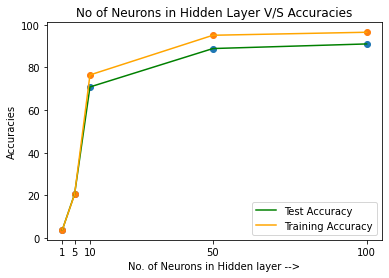

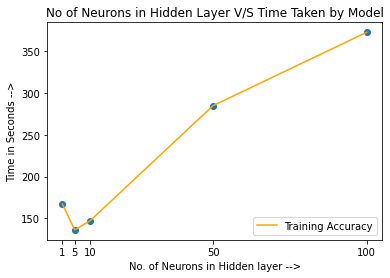

In [0]:
#-----------Question_(b)--------------------
que_b_c('fixed')

  0%|          | 1/1500 [00:00<03:10,  7.88it/s]

classes : 26
layer no : 0 No of neurons : 1 No of weights : 785 (1, 785)
layer no : 1 No of neurons : 26 No of weights : 2 (26, 2)


100%|██████████| 1500/1500 [02:46<00:00,  9.04it/s]


Error : 48.076845640020814
No of total values Match : 13000
number of correct match : 473
Accuracy:  3.6384615384615384


  0%|          | 1/1500 [00:00<02:30,  9.96it/s]

No of total values Match : 6500
number of correct match : 246
Accuracy:  3.7846153846153845
classes : 26
layer no : 0 No of neurons : 5 No of weights : 785 (5, 785)
layer no : 1 No of neurons : 26 No of weights : 6 (26, 6)


100%|██████████| 1500/1500 [02:17<00:00, 10.94it/s]


Error : 48.075773796398835
No of total values Match : 13000
number of correct match : 491
Accuracy:  3.776923076923077


  0%|          | 1/1500 [00:00<02:39,  9.42it/s]

No of total values Match : 6500
number of correct match : 245
Accuracy:  3.769230769230769
classes : 26
layer no : 0 No of neurons : 10 No of weights : 785 (10, 785)
layer no : 1 No of neurons : 26 No of weights : 11 (26, 11)


100%|██████████| 1500/1500 [02:30<00:00,  9.98it/s]


Error : 46.042369941378745
No of total values Match : 13000
number of correct match : 1243
Accuracy:  9.561538461538461


  0%|          | 0/1500 [00:00<?, ?it/s]

No of total values Match : 6500
number of correct match : 648
Accuracy:  9.96923076923077
classes : 26
layer no : 0 No of neurons : 50 No of weights : 785 (50, 785)
layer no : 1 No of neurons : 26 No of weights : 51 (26, 51)


100%|██████████| 1500/1500 [04:51<00:00,  5.15it/s]


Error : 10.2362558787087


  0%|          | 0/1500 [00:00<?, ?it/s]

No of total values Match : 13000
number of correct match : 11557
Accuracy:  88.9
No of total values Match : 6500
number of correct match : 5569
Accuracy:  85.67692307692307
classes : 26
layer no : 0 No of neurons : 100 No of weights : 785 (100, 785)
layer no : 1 No of neurons : 26 No of weights : 101 (26, 101)


100%|██████████| 1500/1500 [06:16<00:00,  3.98it/s]


Error : 8.618107306728461
No of total values Match : 13000
number of correct match : 11707
Accuracy:  90.05384615384615
No of total values Match : 6500
number of correct match : 5630
Accuracy:  86.61538461538461
Training Accuracies : [3.64, 3.78, 9.56, 88.9, 90.05]
Testing Accuracies : [3.78, 3.77, 9.97, 85.68, 86.62]
Time Taken : [166, 137, 150, 291, 377]


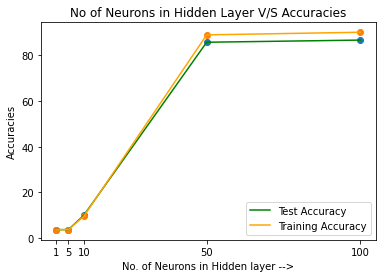

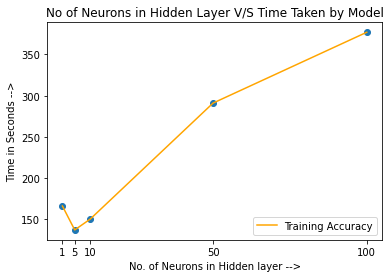

In [0]:
#-----------Question_(c)--------------------
que_b_c('adaptive')

In [0]:
#Que2(d)------- 
print('Activation function : sigmoid')
t0 = time.time()
layers = train([100,100], 100, X, Y, 1500, 'sigmoid',0.5,'adaptive')
print('time to train the model with sigmoid activation function',(time.time()-t0)/60)
get_accuracy(layers, X, Y, 'sigmoid')
get_accuracy(layers, test_features, test_labels, 'sigmoid')
print('Activation function : Relu')
t0 = time.time()
layers = train([100,100], 100, X, Y, 1000, 'relu',0.5,'adaptive',0.01)
print('time to train the model with relu activation function',(time.time()-t0)/60)
get_accuracy(layers, X, Y, 'relu')
get_accuracy(layers, test_features, test_labels, 'relu')

  0%|          | 0/1500 [00:00<?, ?it/s]

Activation function : sigmoid
classes : 26
layer no : 0 No of neurons : 100 No of weights : 785 (100, 785)
layer no : 1 No of neurons : 100 No of weights : 101 (100, 101)
layer no : 2 No of neurons : 26 No of weights : 101 (26, 101)


100%|██████████| 1500/1500 [07:49<00:00,  3.19it/s]


Error : 18.179461946737852
time to train the model with sigmoid activation function 7.827200822035471


  0%|          | 0/1000 [00:00<?, ?it/s]

No of total values Match : 13000
number of correct match : 10454
Accuracy:  80.41538461538461
No of total values Match : 6500
number of correct match : 5120
Accuracy:  78.76923076923077
Activation function : Relu
classes : 26
layer no : 0 No of neurons : 100 No of weights : 785 (100, 785)
layer no : 1 No of neurons : 100 No of weights : 101 (100, 101)
layer no : 2 No of neurons : 26 No of weights : 101 (26, 101)


100%|██████████| 1000/1000 [05:40<00:00,  2.94it/s]


Error : 6.479542616578245
time to train the model with relu activation function 5.6754480759302774
No of total values Match : 13000
number of correct match : 11918
Accuracy:  91.67692307692307
No of total values Match : 6500
number of correct match : 5671
Accuracy:  87.24615384615385


87.25

In [11]:
#--------Que2(E)
print('--part_e, sigmoid--')
t0 = time.time()
mlp_clf = mlp_classifier(X,Y,1500,0.5,'logistic')
print('time to train the model :',time.time()-t0)
mlp_cal_accuracy(mlp_clf,X, y_train)
mlp_cal_accuracy(mlp_clf,test_features, test_y)

print('--part_e, relu--')
t0 = time.time()
mlp_clf = mlp_classifier(X,Y,1500,0.5,'relu',0)
print('time to train the model :',time.time()-t0)
mlp_cal_accuracy(mlp_clf,X, y_train)
mlp_cal_accuracy(mlp_clf,test_features, test_y)

--part_e, sigmoid--
time to train the model : 519.7103900909424
Matched : 1133 Total examples : 13000
0.08715384615384615
Matched : 574 Total examples : 6500
0.08830769230769231
--part_e, relu--


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


time to train the model : 1049.4873569011688
Matched : 10969 Total examples : 13000
0.8437692307692307
Matched : 5309 Total examples : 6500
0.8167692307692308
